In [1]:
from collections import defaultdict
from dataclasses import dataclass
import os
import sys
import yaml
import time
import numpy as np
import scipy.io
import scipy.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt
from src.common import NDArrayFloat
from src.linalg import get_numpy_eigenvalues
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import RectBivariateSpline


In [2]:
def generate_matrix(type: str, sparse: bool, size: int, min_val: float, max_val: float, grouping_factor: float = 0, density: float = 1) -> np.array:
  """Generates various types of REAL matrices with controlled value range and diagonal grouping.

  Args:
    type: The type of matrix to generate.
          Options: 'nonsymmetric', 'symmetric', 'normal', 'orthogonal'.
    sparse: Whether to generate a sparse matrix.
    size: The size of the matrix (size x size).
    min_val: Minimum value of the matrix elements.
    max_val: Maximum value of the matrix elements.
    grouping_factor: Controls the strength of diagonal grouping. 
                     0: No grouping.
                     Positive values: Increase grouping strength.

  Returns:
    A NumPy array representing the generated matrix.
  """
  
  seed = 42
  np.random.seed(seed)
  
  if type == 'nonsymmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr').toarray()
    else:
      A = np.random.rand(size, size)
    if grouping_factor > 0:
      for i in range(size):
        A[i, :] = A[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
    return A * (max_val - min_val) + min_val

  elif type == 'symmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr')
      A = (A + A.transpose()).toarray() / 2
    else:
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
    if grouping_factor > 0:
      for i in range(size):
        for j in range(size):
          A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
    return A * (max_val - min_val) + min_val

  elif type == 'normal':
    if sparse:
      raise ValueError("Sparse normal matrices are not well-defined.")
    else:
      # Generate a symmetric matrix (guaranteed to be normal)
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
      if grouping_factor > 0:
        for i in range(size):
          for j in range(size):
            A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
      return A * (max_val - min_val) + min_val

  elif type == 'orthogonal':
    if sparse:
      raise ValueError("Sparse orthogonal matrices are not well-defined.")
    else:
      Q, _ = np.linalg.qr(np.random.rand(size, size))
      if grouping_factor > 0:
        for i in range(size):
          Q[i, :] = Q[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
      return Q * (max_val - min_val) + min_val

  else:
    raise ValueError(f"Invalid matrix type: {type}")

In [3]:
def plot_matrix_3d(matrix: np.array, title: str = "Matrix 3D Plot"):
  """Plots a matrix as a 3D surface plot.

  Args:
    matrix: The NumPy array representing the matrix.
    title: The title for the plot (optional).
  """

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Create the grid for x and y coordinates
  rows, cols = matrix.shape
  x = np.arange(cols)
  y = np.arange(rows)
  X, Y = np.meshgrid(x, y)

  # Plot the surface
  surf = ax.plot_surface(X, Y, matrix, cmap=cm.viridis)

  # Add labels and title
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Value")
  ax.set_title(title)

  # Add a colorbar
  fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

  plt.show()


In [4]:
def plot_2d_temperature(matrix, title="Temperature Plot of Matrix"):
  """
  Plots a 2D temperature map of a matrix, highlighting the largest elements.

  Args:
    matrix: The input numpy array (matrix).
    title: The title of the plot.
  """

  fig, ax = plt.subplots()

  # Plot the temperature map
  im = ax.imshow(matrix, cmap='hot', interpolation='nearest')

  # Add a colorbar
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('Value')

  # Add labels and title
  ax.set_xlabel('Column Index')
  ax.set_ylabel('Row Index')
  ax.set_title(title)

  plt.show()

In [5]:
def testing(my_function, A: np.array, name: str,show_plots: bool=False, function_name: str="My_func"):
  """Compares your eigenvalue algorithm with NumPy's eigvals.

  Args:
    my_function: function that takes a NumPy array (matrix) and returns a NumPy array of eigenvalues.
    A: The input matrix for eigenvalue calculation.
  """


  start_time = time.time()
  my_eigenvalues = my_function(A)
  my_time = time.time() - start_time

  start_time = time.time()
  numpy_eigenvalues = np.linalg.eigvals(A)
  numpy_time = time.time() - start_time

  my_eigenvalues.sort()
  numpy_eigenvalues.sort()

  # Accuracy
  errors = np.abs(my_eigenvalues - numpy_eigenvalues)
  max_error = np.max(errors)
  avg_error = np.mean(errors)

  print("----------")
  print(f'{name}:')
  print("  Time:", my_time, "seconds")
  print("NumPy eigvals:")
  print("  Time:", numpy_time, "seconds")
  print("\nAccuracy:")
  print("  Maximum Error:", max_error)
  print("  Average Error:", avg_error)
  print("----------\n")
  if(show_plots):
    # Plot the differences
    plt.figure(figsize=(8, 6))
    plt.plot(my_eigenvalues, label=function_name)
    plt.plot(numpy_eigenvalues, label="NumPy eigvals")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.title("Eigenvalue Comparison")
    plt.legend()
    plt.show()

    # Plot the errors
    plt.figure(figsize=(8, 6))
    plt.plot(errors)
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Absolute Error")
    plt.title("Eigenvalue Errors")
    plt.show()


In [6]:
def test_all(matrix_dict: dict, my_function,show_plots: bool=False,skip_matrices_id: list=[], function_name: str="My_function"):
    for matrix_id,items in matrix_dict.items():
        if(matrix_id in skip_matrices_id): continue
        name = items[1]
        matrix = items[0]
        testing(my_function=my_function,A=matrix,name=name,show_plots=show_plots, function_name=function_name)
        if(show_plots):
            plot_2d_temperature(matrix=matrix,title=name)

In [7]:
nonsymmetric_matrix_sparse = generate_matrix('nonsymmetric', True, 500, 100, 1000,density=0.2)
nonsymmetric_matrix_bottom_group = generate_matrix('nonsymmetric', False, 500, 100, 1000,grouping_factor=1000)
symmetric_matrix = generate_matrix('symmetric', False, 500, 0, 10)
symmetric_matrix_diag = generate_matrix('symmetric', False, 500, 0, 10,grouping_factor=5)
orthogonal_matrix = generate_matrix('orthogonal', False, 500, 0, 1)
symmetric_matrix_diag_sparse = generate_matrix('symmetric', True, 1000, 0, 1000,grouping_factor=3,density=0.3)
symmetric_matrix_small = generate_matrix('symmetric', False, 25, 0, 1)

matrix_dict = {
    1 : [nonsymmetric_matrix_sparse, "nonsymmetric_matrix_sparse"],
    2 : [nonsymmetric_matrix_bottom_group, "nonsymmetric_matrix_bottom_group"],
    3 : [symmetric_matrix,"symmetric_matrix"],
    4 : [symmetric_matrix_diag, "symmetric_matrix_diag"],
    5 : [orthogonal_matrix, "orthogonal_matrix"],
    6 : [symmetric_matrix_diag_sparse, "symmetric_matrix_diag_sparse"],
    7 : [symmetric_matrix_small, "symmetric_matrix_small"],
}

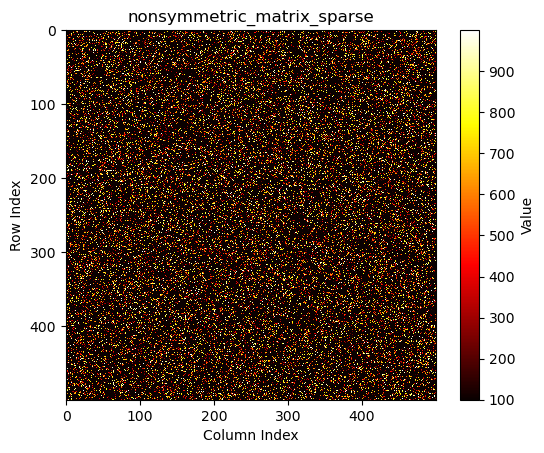

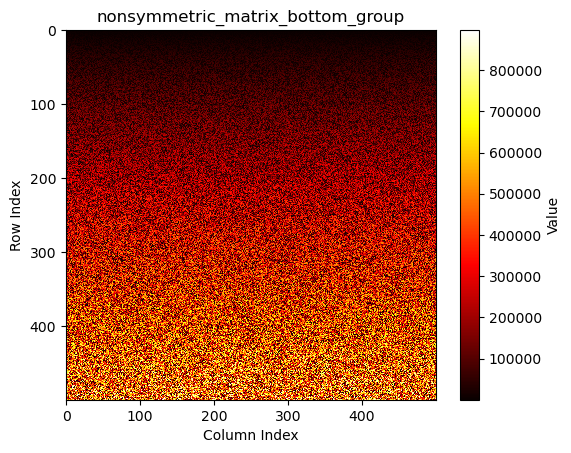

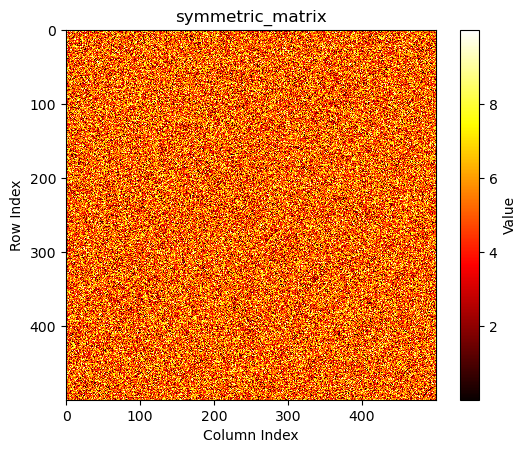

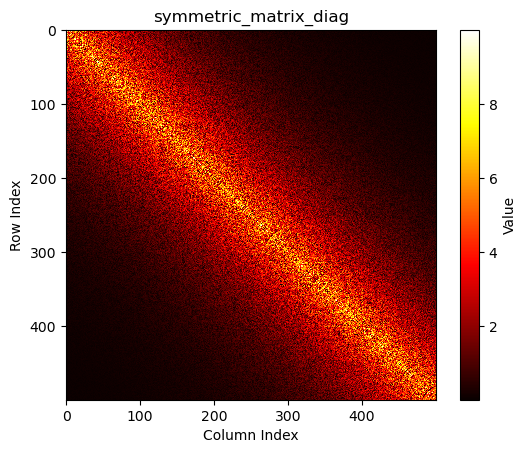

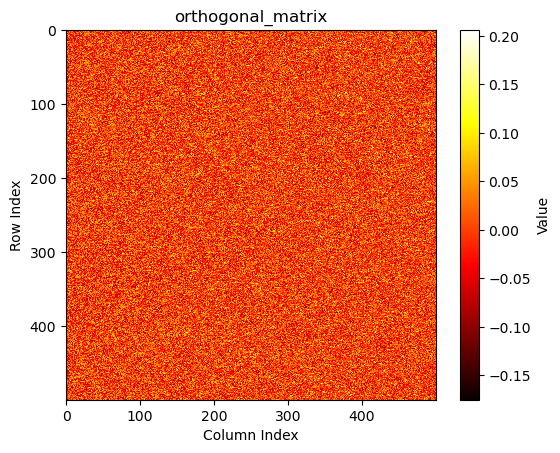

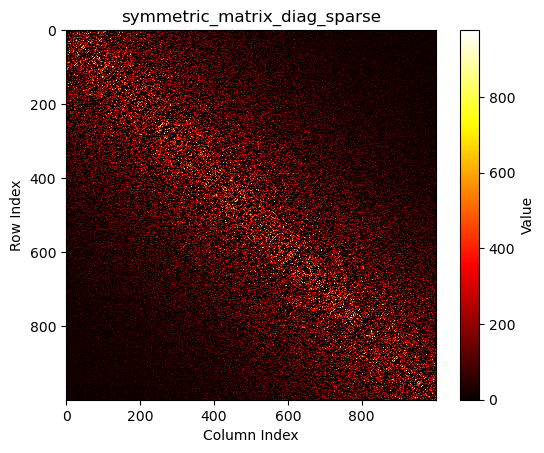

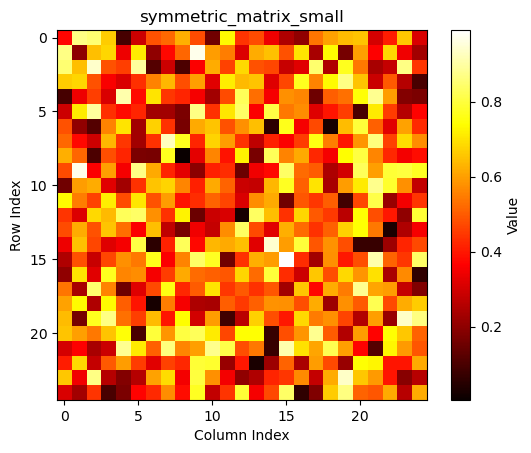

In [8]:
for matrix_id,items in matrix_dict.items():
    name = items[1]
    matrix = items[0]
    plot_2d_temperature(matrix=matrix,title=name)

In [9]:
def get_all_eigenvalues(A, tol=1e-6, max_iter=500):
    """
    Finds all eigenvalues of a real symmetric matrix using the Jacobi method.

    Args:
        A: The input symmetric matrix (numpy array).
        tol: Tolerance for off-diagonal elements.
        max_iter: Maximum number of iterations.

    Returns:
        eigenvalues: A numpy array of eigenvalues.
    """

    n = A.shape[0]
    eigenvalues = np.diag(A).copy() # Initial eigenvalues are the diagonal elements

    for _ in range(max_iter):
        # Find the largest off-diagonal element in magnitude
        max_off_diag = 0
        p, q = 0, 0
        for i in range(n):
            for j in range(i + 1, n):
                if abs(A[i, j]) > max_off_diag:
                    max_off_diag = abs(A[i, j])
                    p, q = i, j

        if max_off_diag < tol: # Convergence check
            break

        # Calculate rotation angle
        theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])

        # Construct rotation matrix
        R = np.eye(n)
        R[p, p] = np.cos(theta)
        R[q, q] = np.cos(theta)
        R[p, q] = -np.sin(theta)
        R[q, p] = np.sin(theta)

        # Apply rotation
        A = R.T @ A @ R
        eigenvalues = np.diag(A)
    eigenvalues = np.array(eigenvalues, dtype=np.float64)
    print("Jacobi method")
    eigenvalues = np.array(eigenvalues, dtype=np.float64)
    return eigenvalues


# Matrix: e05r0100.mtx.gz. Average time: 2.75e+00 seconds. Relative error: 3.44e-01
# Matrix: fs_541_1.mtx.gz. Average time: 1.48e+01 seconds. Relative error: 2.68e-04
# Matrix: hor__131.mtx.gz. Average time: 1.09e+01 seconds. Relative error: 1.37e-01
# Matrix: impcol_c.mtx.gz. Average time: 1.83e+00 seconds. Relative error: 6.85e-01
# Matrix: impcol_d.mtx.gz. Average time: 1.06e+01 seconds. Relative error: 7.81e-01
# Matrix: impcol_e.mtx.gz. Average time: 2.41e+00 seconds. Relative error: 1.00e+00
# Matrix: lns__511.mtx.gz. Average time: 1.39e+01 seconds. Relative error: 1.00e+00
# Matrix: mcca.mtx.gz. Average time: 1.73e+00 seconds. Relative error: 9.28e-02
# Matrix: nos5.mtx.gz. Average time: 1.01e+01 seconds. Relative error: 5.48e-02


# Jacobi method
# ----------
# symmetric_matrix:
#   Time: 9.817148923873901 seconds
# NumPy eigvals:
#   Time: 0.08132195472717285 seconds

# Accuracy:
#   Maximum Error: 2290.4878132925287
#   Average Error: 40.477225051963615
# ----------

# Jacobi method
# ----------
# symmetric_matrix_diag:
#   Time: 10.932776927947998 seconds
# NumPy eigvals:
#   Time: 0.07661199569702148 seconds

# Accuracy:
#   Maximum Error: 609.4119236055935
#   Average Error: 17.814331852048475
# ----------

# Jacobi method
# ----------
# symmetric_matrix_diag_sparse:
#   Time: 43.900062084198 seconds
# NumPy eigvals:
#   Time: 0.35826706886291504 seconds

# Accuracy:
#   Maximum Error: 61010.221934731366
#   Average Error: 2569.0218523775593
# ----------

# Jacobi method
# ----------
# symmetric_matrix_small:
#   Time: 0.039395809173583984 seconds
# NumPy eigvals:
#   Time: 0.00022101402282714844 seconds

# Accuracy:
#   Maximum Error: 1.2954143976497932
#   Average Error: 0.6649596510846654
# ----------



Jacobi method
----------
symmetric_matrix:
  Time: 10.860823154449463 seconds
NumPy eigvals:
  Time: 0.07658982276916504 seconds

Accuracy:
  Maximum Error: 2290.4878132925287
  Average Error: 40.477225051963615
----------



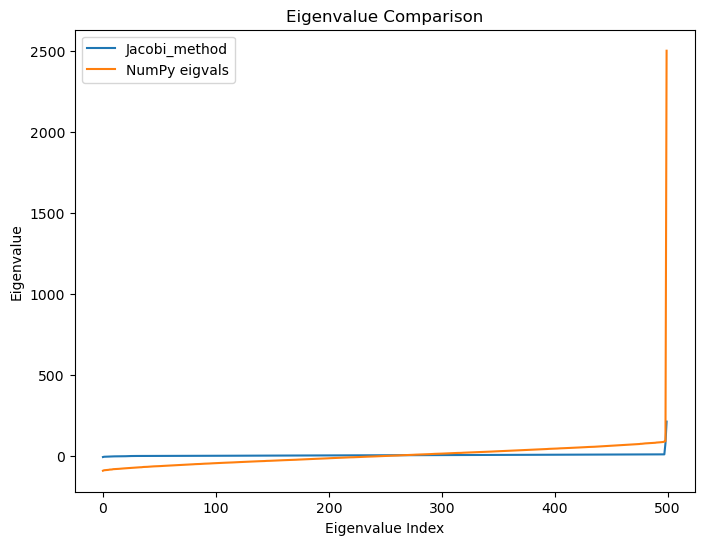

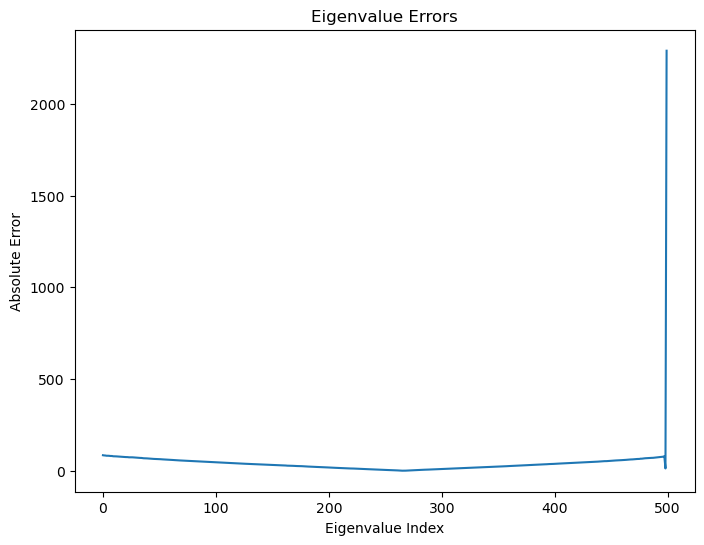

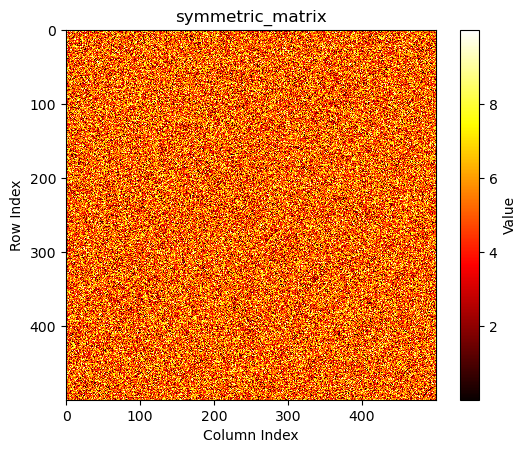

Jacobi method
----------
symmetric_matrix_diag:
  Time: 10.544891119003296 seconds
NumPy eigvals:
  Time: 0.06704831123352051 seconds

Accuracy:
  Maximum Error: 609.4119236055935
  Average Error: 17.814331852048475
----------



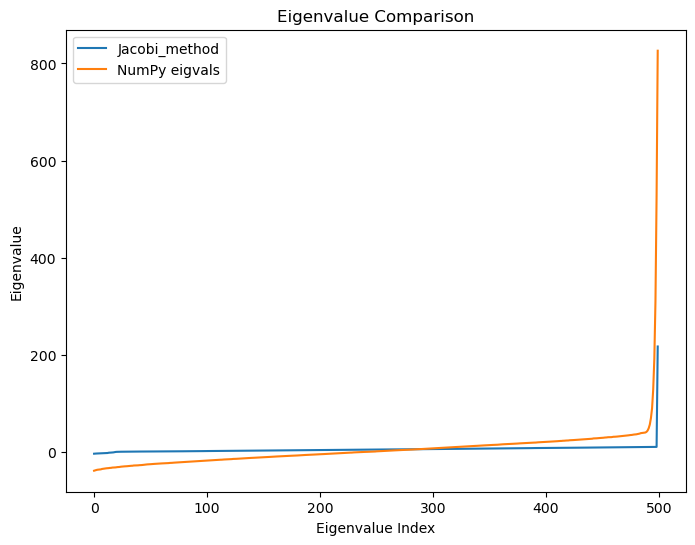

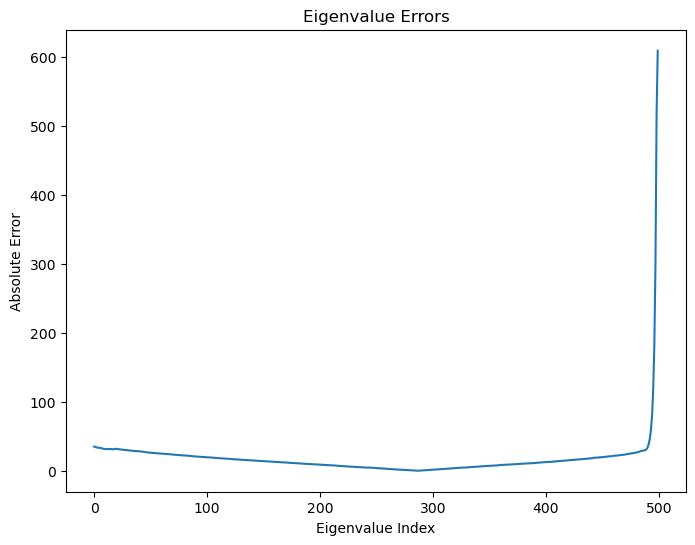

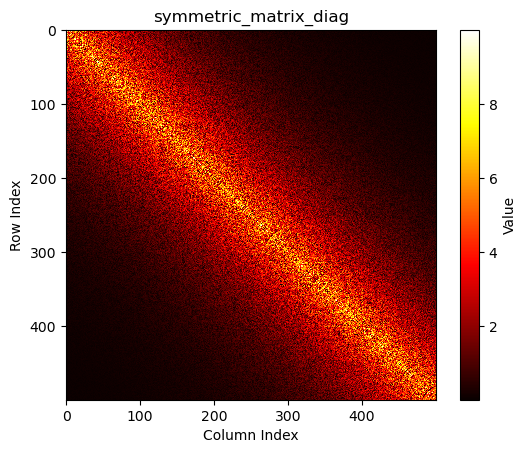

Jacobi method
----------
symmetric_matrix_diag_sparse:
  Time: 46.16958689689636 seconds
NumPy eigvals:
  Time: 0.4169042110443115 seconds

Accuracy:
  Maximum Error: 61010.221934731366
  Average Error: 2569.0218523775593
----------



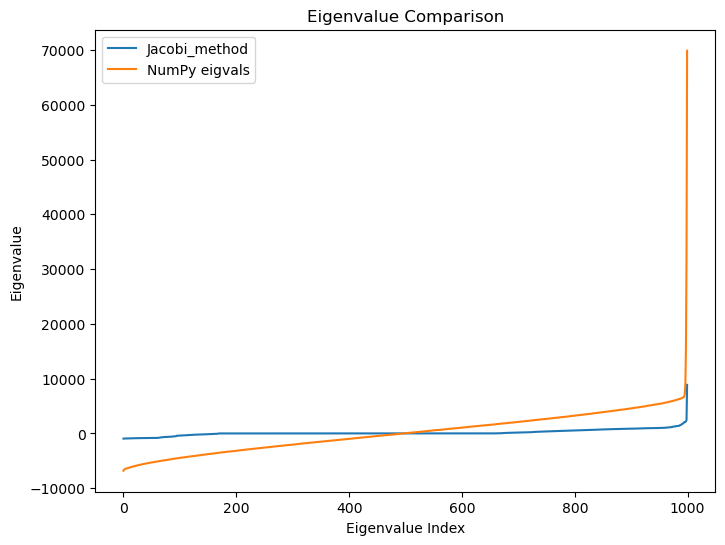

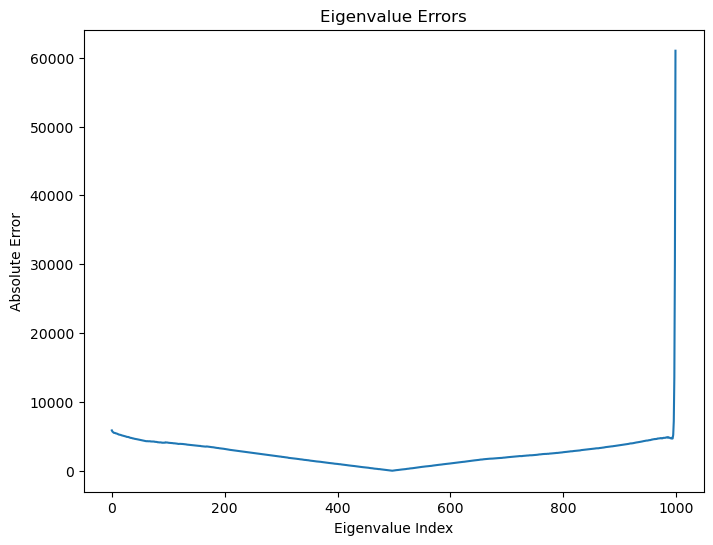

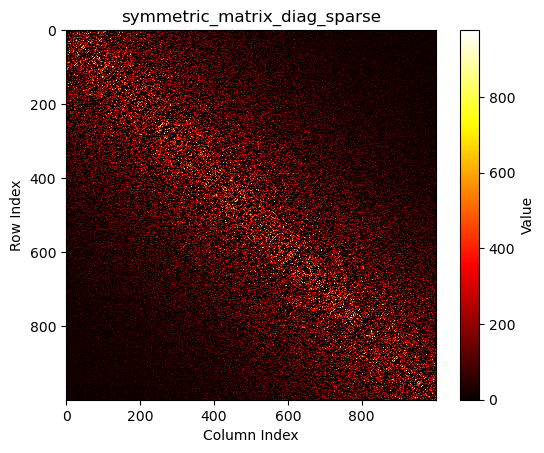

Jacobi method
----------
symmetric_matrix_small:
  Time: 0.016810894012451172 seconds
NumPy eigvals:
  Time: 0.00010704994201660156 seconds

Accuracy:
  Maximum Error: 1.2954143976497932
  Average Error: 0.6649596510846654
----------



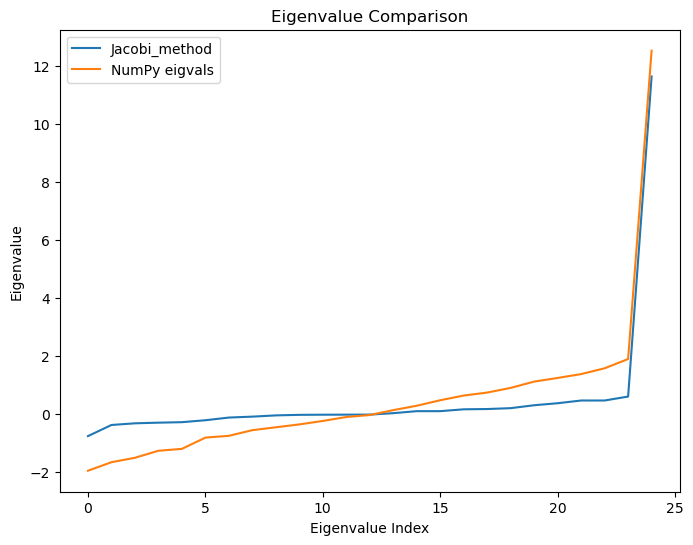

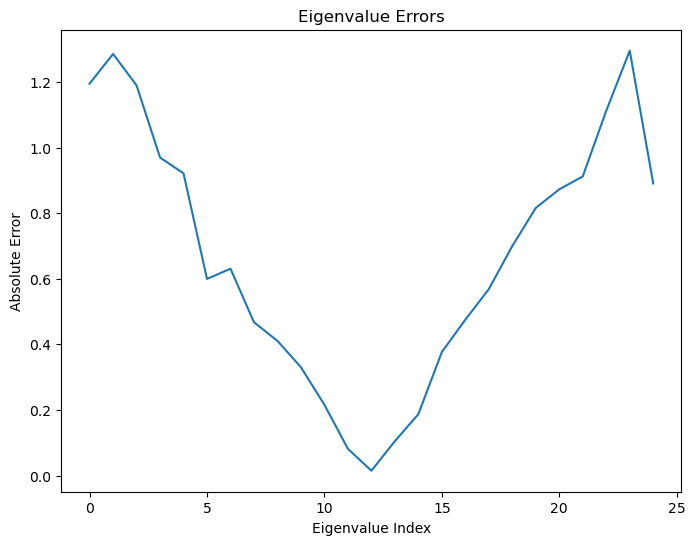

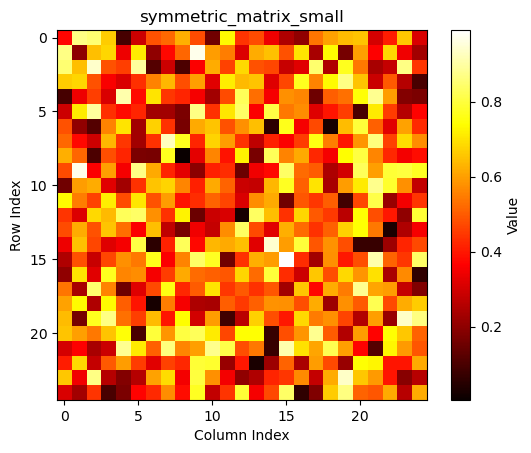

In [11]:
test_all(matrix_dict=matrix_dict,my_function=get_all_eigenvalues,show_plots=True,skip_matrices_id = [1,2,5], function_name="Jacobi_method")